# CSE 40 Take-Home Final: erduong

Your unique dataset consists of physiochemical properties of a selection of Portuguese Vinho Verde wines.

Some wines are red, some are white. A boolean label for high-quality white wines has been provided.

You are free to use any library code provided within the `cse40` conda environment.

In [1]:
import re

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.model_selection import KFold, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler

# You may import sklearn models of your choosing. For example,
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


df = pd.read_csv('data.csv')

df.head()

,pH,total sulfur dioxide,chlorides,residual sugar,citric acid,quality white
0,3.13,125.0 mg/dm^3,0.021 g(sodium chloride)/dm^3,5.7 g/dm^3,0.38 g/dm^3,True
1,3.05,111.0 mg/dm^3,0.04 g(sodium chloride)/dm^3,9.5 g/dm^3,0.22 g/dm^3,False
2,3.27,218.5 mg/dm^3,0.042 g(sodium chloride)/dm^3,2.5 g/dm^3,0.32 g/dm^3,False
3,3.22,138.0 mg/dm^3,0.047 g(sodium chloride)/dm^3,2.1 g/dm^3,0.3 g/dm^3,False
4,3.24,99.0 mg/dm^3,0.038 g(sodium chloride)/dm^3,5.1 g/dm^3,0.34 g/dm^3,True


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pH                    998 non-null    float64
 1   total sulfur dioxide  1000 non-null   object 
 2   chlorides             999 non-null    object 
 3   residual sugar        1000 non-null   object 
 4   citric acid           1000 non-null   object 
 5   quality white         1000 non-null   bool   
dtypes: bool(1), float64(1), object(4)
memory usage: 40.2+ KB


In [3]:
# print(df.dtypes)
# df['total sulfur dioxide'] = df['total sulfur dioxide'].astype(float)
# print(df.dtypes)

# cleaning up the data
# removing any string within the data to convert the data set to hold only floats
# this way, we can utilize the information with floats instead of objects


df['total sulfur dioxide'] = df['total sulfur dioxide'].str[0:-7].astype(float)

df['chlorides'] = df['chlorides'].str[0:-23].astype(float)

df['residual sugar'] = df['residual sugar'].str[0:-6].astype(float)

df['citric acid'] = df['citric acid'].str[0:-6].astype(float)

print(df)





       pH  total sulfur dioxide  chlorides  residual sugar  citric acid  \
0    3.13                 125.0      0.021             5.7         0.38   
1    3.05                 111.0      0.040             9.5         0.22   
2    3.27                 218.5      0.042             2.5         0.32   
3    3.22                 138.0      0.047             2.1         0.30   
4    3.24                  99.0      0.038             5.1         0.34   
..    ...                   ...        ...             ...          ...   
995  3.07                  94.0      0.052            15.8         0.48   
996  3.02                  41.0      0.095             1.5         0.54   
997  3.49                  97.0      0.031             1.2         0.28   
998  3.35                  15.0      0.093             1.8         0.01   
999  3.15                 101.0      0.035             3.2         0.43   

     quality white  
0             True  
1            False  
2            False  
3            Fa

In [4]:
# cleaning out all outlying data
# drops all rows with null values

# keeping average of each column in case we need it for future use
# average_pH = np.mean(df['pH'])
# average_total_sulfur_dioxide = np.mean(df['total sulfur dioxide'])
# average_chlorides = np.mean(df['chlorides'])
# average_residual_sugar = np.mean(df['residual sugar'])
# average_citric_acid = np.mean(df['citric acid'])

# turning all outlying values and nan values
# later dropping all nan values, so when training the model, there will be no interference

df.loc[df.pH < 0, 'pH'] = np.nan
df.loc[df.pH > 14, 'pH'] = np.nan

df.loc[df['total sulfur dioxide'] < 0, ['total sulfur dioxide']] = np.nan

df.loc[df['chlorides'] < 0, ['chlorides']] = np.nan
df.loc[df['chlorides'] > 1, ['chlorides']] = np.nan


df.loc[df['residual sugar'] < 0, ['residual sugar']] = np.nan


df.loc[df['citric acid'] > 1, ['citric acid']] = np.nan
df.loc[df['citric acid'] < 0, ['citric acid']] = np.nan

df = df.dropna()

df.describe()

,pH,total sulfur dioxide,chlorides,residual sugar,citric acid
count,995.000000,995.000000,995.000000,995.000000,995.000000
mean,3.216945,114.236181,0.055708,5.347538,0.315417
std,0.158445,56.741551,0.031528,4.708691,0.143140
min,2.770000,7.000000,0.014000,0.600000,0.000000
25%,3.110000,75.000000,0.038000,1.800000,0.240000
50%,3.210000,118.000000,0.047000,2.950000,0.310000
75%,3.320000,156.000000,0.067000,7.900000,0.390000
max,3.800000,313.000000,0.413000,31.600000,1.000000


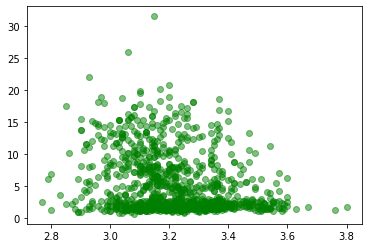

In [5]:
#data visualization
#plotting relationships between pH and other values

label_column = 'quality white'

pH = 'pH'
tsd = 'total sulfur dioxide'
chl = 'chlorides'
rs = 'residual sugar'
ca = 'citric acid'

xlabel = df[pH]
ylabel = df[tsd] # no correlation
ylabel = df[chl] # clustered chlorides of 0.01-0.1 at around 3.0-3.4 pH
ylabel = df[rs]  # clustered residual sugar of 1-3 at around 3.0-3.4 pH
# ylabel = df[ca]  # no correlation

plt.scatter(xlabel, ylabel, alpha=0.5, c='g')

# feature_columns = [col0, col1]

plt.show()

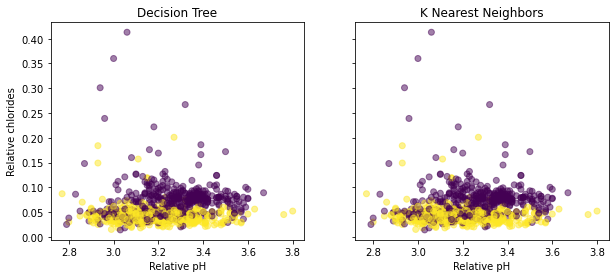

In [6]:
#training the model with pH and chloride using decision tree and knn
def q1(model, df, X, y):

    model.fit(X,y.values.ravel())
    return None

def train_with_chloride():
    
    X = df[['pH', 'chlorides']]
    y = df[['quality white']]

    # instantiate and train models --------------------------------------------------
    tree_model = DecisionTreeClassifier(
        criterion='entropy',
        max_depth=10
    )
    knn_model = KNeighborsClassifier(
        n_neighbors=10
    )

    # suppress errors
    tree_model.fit(np.array([[1,1]]), np.array([[1]]).ravel())
    knn_model.fit(np.array([[1,1]]*10), np.array([[1]]*10).ravel())

    # call your function
    q1(tree_model, df, X, y)
    q1(knn_model, df, X, y)

    # plot decision boundaries ------------------------------------------------------
    features = ['pH', 'chlorides']
    label = ['quality white']

    # data range
    x_min, x_max = df[features[0]].min() - 1, df[features[0]].max() + 1
    y_min, y_max = df[features[1]].min() - 1, df[features[1]].max() + 1

    # meshgrid
    res = (x_max - x_min) / 100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, res), np.arange(y_min, y_max, res))


    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
    ax1.scatter(df[features[0]], df[features[1]], c=np.array(df[label] > 0), alpha=0.5)
    ax1.set_xlabel(f'Relative {features[0]}'), 
    ax1.set_ylabel(f'Relative {features[1]}'), ax1.set_title('Decision Tree')

    ax2.scatter(df[features[0]], df[features[1]], c=np.array(df[label] > 0), alpha=0.5)
    ax2.set_xlabel(f'Relative {features[0]}'), ax2.set_title('K Nearest Neighbors')

    plt.show()

train_with_chloride()

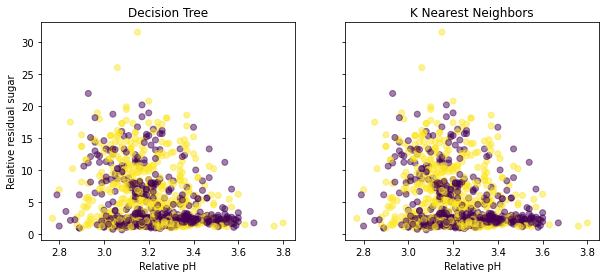

In [7]:
#training the model with pH and residual sugar values using decision tree and knn 

def train_with_rs():
    
    X = df[['pH', 'residual sugar']]
    y = df[['quality white']]

    # instantiate and train models --------------------------------------------------
    tree_model = DecisionTreeClassifier(
        criterion='entropy',
        max_depth=10
    )
    knn_model = KNeighborsClassifier(
        n_neighbors=10
    )

    # suppress errors
    tree_model.fit(np.array([[1,1]]), np.array([[1]]).ravel())
    knn_model.fit(np.array([[1,1]]*10), np.array([[1]]*10).ravel())

    # call your function
    q1(tree_model, df, X, y)
    q1(knn_model, df, X, y)

    # plot decision boundaries ------------------------------------------------------
    features = ['pH', 'residual sugar']
    label = ['quality white']

    # data range
    x_min, x_max = df[features[0]].min() - 1, df[features[0]].max() + 1
    y_min, y_max = df[features[1]].min() - 1, df[features[1]].max() + 1

    # meshgrid
    res = (x_max - x_min) / 100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, res), np.arange(y_min, y_max, res))

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
    ax1.scatter(df[features[0]], df[features[1]], c=np.array(df[label] > 0), alpha=0.5)
    ax1.set_xlabel(f'Relative {features[0]}'), 
    ax1.set_ylabel(f'Relative {features[1]}'), ax1.set_title('Decision Tree')

    ax2.scatter(df[features[0]], df[features[1]], c=np.array(df[label] > 0), alpha=0.5)
    ax2.set_xlabel(f'Relative {features[0]}'), ax2.set_title('K Nearest Neighbors')

    plt.show()

train_with_rs()

In [8]:
#training the model with pH and chlorides values using ensemble

X = df[['pH', 'chlorides']]
y = df[['quality white']]


# instantiate and train models --------------------------------------------------
tree_model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=10
)
knn_model = KNeighborsClassifier(
    n_neighbors=10
)

# suppress errors
tree_model.fit(np.array([[1,1]]), np.array([[1]]).ravel())
knn_model.fit(np.array([[1,1]]*10), np.array([[1]]*10).ravel())

bag = BaggingClassifier(
    tree_model,
    max_samples = .5, #taking 50% to train, take the rest to test
    max_features = 2,
    n_jobs = 2,
    oob_score = True
)

bag.fit(X, y.values.ravel())
print("out of bag score:", bag.oob_score_) # out of bag score
print("after ensemble classifier:", bag.score(X,y)) # actual score after fitting


out of bag score: 0.7266331658291457
after ensemble classifier: 0.8522613065326633


In [9]:
   
def K_Fold_Validate(models, kf, X, y):
    
    # initialize dictionary to hold scores
    scores = {
        name: [] for name in models
    }
    
    for train_index, test_index in kf.split(X):
    
        # split training test sets by index
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # compute the cross-validation score for each model
        # using the same splits
        for name, model in models.items():

            model.fit(X_train, y_train.to_numpy().ravel())
        
            scores[name].append(
                f1_score(y_test, model.predict(X_test), zero_division=0)
            )

    return {k: np.array(v) for k, v in scores.items()}


#k-fold cross-validation score

tree_model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=5,
    random_state=0
)
knn_model = KNeighborsClassifier(
    n_neighbors=8
)

bag = BaggingClassifier(
    tree_model,
    max_samples = .5, #taking 50% to train, take the rest to test
    max_features = 2,
    n_jobs = 2,
    oob_score = True
)


models = {
    'tree': tree_model, 
    'KNN': knn_model,
    'bag': bag
}

#for first case
features = ['pH', 'chlorides']
label = ['quality white']

X, y = df[features], df[label]

k = 10
kf = KFold(k)

scores = K_Fold_Validate(models, kf, X, y)


print("test case 1 with pH and chlorides:")
for k, v in scores.items():
    print(k, v)
print()


#for tsecond case
features = ['pH', 'residual sugar']

X, y = df[features], df[label]

scores = K_Fold_Validate(models, kf, X, y)
print("test case 2 with pH and residual sugar:")
for k, v in scores.items():
    print(k, v)
    

     

/home/osboxes/miniconda3/envs/cse40/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:640: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/osboxes/miniconda3/envs/cse40/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:644: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = (predictions /
/home/osboxes/miniconda3/envs/cse40/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:640: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/osboxes/miniconda3/envs/cse40/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:644: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = (predictions /


test case 1 with pH and chlorides:
tree [0.75247525 0.8        0.76666667 0.75       0.77477477 0.71028037
 0.68       0.72727273 0.72527473 0.8173913 ]
KNN [0.6746988  0.66019417 0.72222222 0.6875     0.81818182 0.67368421
 0.73267327 0.67272727 0.7654321  0.76470588]
bag [0.78       0.73684211 0.77310924 0.75       0.80701754 0.74336283
 0.81415929 0.68376068 0.73333333 0.79310345]



/home/osboxes/miniconda3/envs/cse40/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:640: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/osboxes/miniconda3/envs/cse40/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:644: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = (predictions /
/home/osboxes/miniconda3/envs/cse40/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:640: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/osboxes/miniconda3/envs/cse40/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:644: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = (predictions /


test case 2 with pH and residual sugar:
tree [0.59090909 0.63157895 0.60194175 0.65957447 0.65384615 0.70491803
 0.64705882 0.62385321 0.60240964 0.64220183]
KNN [0.53012048 0.63043478 0.67307692 0.5        0.65346535 0.73267327
 0.54545455 0.58695652 0.51351351 0.63157895]
bag [0.66666667 0.69724771 0.65420561 0.72380952 0.67924528 0.72072072
 0.67889908 0.60550459 0.59574468 0.64864865]
